# K-Means Clustering Unsupervised Model

**Sites Used**\
[Scikit-Learn KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)\
[Scikit-Learn Clustering](https://scikit-learn.org/stable/modules/clustering.html)\
[NSL-KDD With KMeans](https://notebook.community/nickjmiller/KMeansNSL-KDD/kmeans)\
[KDD'99 Statistical Analysis](https://www.researchgate.net/publication/341077418_A_Statistical_Analysis_on_KDD_Cup%2799_Dataset_for_the_Network_Intrusion_Detection_System)

**Basic Definition**\
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variances, by minimizing a criterion known as 'inertia' or 'within-cluster sum-of-squares'. This is done by first randomly placing k centroids and then iteratively assigning data points to the nearest center (using Euclidean distance measure). The centroids are adjusted as each cluster grows. The assignment process is repeated until all the centroids converge to a maximum or the maximum number of iterations have reached. 

**K-Means for Anomaly Detection**\
After the clusters have been formed, the distances of each data point to its center can be calculated. Points that are from their cluster center are potentially anomalous because they don't fit well with any cluster. Anomalies can also be bunched together to form very small clusters. A threshold can then be set in place to determine if a cluster is too small, or a data point is too far. 

**K-Means for KDD'99**\
Because of the large quantity normal traffic ~25%, K-Means can group network traffic into clusters that may correspond to normal traffic and different attack types. We can assume that the data points that do not fit well into any large, well-defined clusters can be flagged as anomalous.

**Limitations**
- Choosing K: A very low K value might oversimplify the data, while too high values may produce too fine-grained clusters, making it difficult to distinguish actual anomalies from noise.
- Cluster Shape Assumption: K-Means assumes clusters to be similarly sized and roughly spherical. Network traffic that strays from this will worsen performance.
- Outliers: By definition any data points / clusters that stray too much are anomalous. Additionally, anomalies themselves can skew cluster centroids.
- Extra Logic: Unlike other models, KMeans doesn't have an inbuilt prediction method, all it does is assign data points to clusters. Extra logic is required for determining data points are anomalous or not.

In [1]:
# Import everything, define hyperparameters and features.
# Load the preprocessed data and apply variance threshold to it.
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

from common_stage import prepareData

# Hyperparameters
hyperparams = {
    # [Clustering Model]
    'k_clusters': 100, # Cluster Amount
    'max_iter': 100,  # Maximum Iterations
    'variance_threshold': 0.0,  # Variance Threshold for Data Features,
    # [Anomaly Detection]
    'per_min_size': 99.5,
    'per_dist': 99.9,
    'w_distance': 0.01, # Centroid Distance Weight for Anomaly Detection
    'w_cluster': 0.8,  # Min Cluster Size Weight for Anomaly Detection
    'score_threshold': 0.65 # Maximum anomaly score for a data point to be classified as an anomaly
}

# Features to be dropped
dropped_features = [
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='standard', removed_features=dropped_features)

# Apply variance threshold to remove low-variance features
selector = VarianceThreshold(hyperparams['variance_threshold'])
x_train = pd.DataFrame(selector.fit_transform(x_train), columns=x_train.columns[selector.get_support()])
x_test = pd.DataFrame(selector.transform(x_test), columns=x_test.columns[selector.get_support()])

print("Data frame shapes after processing stage: ")
print(x_train.shape)
print(x_test.shape)

Data frame shapes after processing stage: 
(493969, 96)
(292261, 96)


---
### Basic Grid Search for KMeans Hyperparameters
```python
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Grid Search Parameters
param_grid = {
    'n_clusters': [4, 20, 100, 400, 800],
    'max_iter': [100, 200, 300, 600]
}

best_score = -np.inf
best_params = {}

print("Now starting grid search...")

for params in ParameterGrid(param_grid):
    # Initialize and fit the KMeans model with the current hyperparameters
    kmeans = KMeans(n_clusters=params['n_clusters'], max_iter=params['max_iter'], random_state=42)
    kmeans.fit(x_train)
    labels = kmeans.labels_
    
    try:
        # Compute the silhouette score using x_train (instead of the undefined x_cluster)
        sil_score = silhouette_score(x_train, labels, sample_size=1000, random_state=42)
        if sil_score > best_score:
            best_score = sil_score
            best_params = params
    except Exception as e:
        continue

print("Best Hyperparameters:", best_params)
print("Best Silhouette Score:", best_score)
```
---

In [2]:
## Train K-Means on training data

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=hyperparams['k_clusters'], max_iter=hyperparams['max_iter'], random_state=42).fit(x_train)
x_train['cluster'] = kmeans.labels_
x_test['cluster'] = kmeans.predict(x_test)

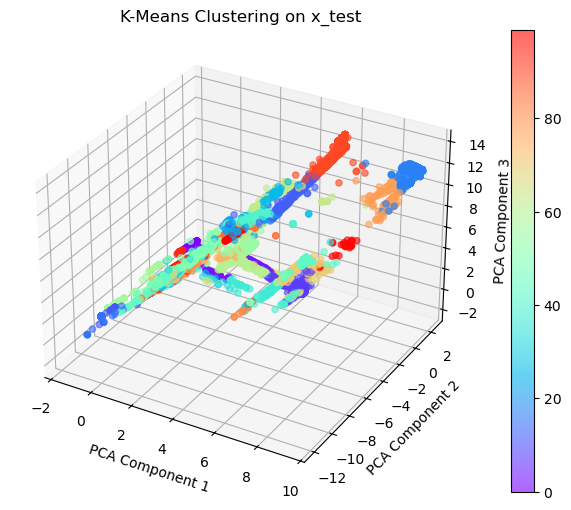

In [3]:
## Create a plot of the clusters in 3D using PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

features = x_test.drop(columns=['cluster'])  # Keep it as a DataFrame
pca = PCA(n_components=3)
X_pca_test = pca.fit_transform(features)

# Transform cluster centers as a DataFrame with the same columns
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
centers_pca = pca.transform(centers_df)
# 3D cluster plot for x_test
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_test[:, 0], X_pca_test[:, 1], X_pca_test[:, 2], c=x_test['cluster'], cmap='rainbow', alpha=0.6)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("K-Means Clustering on x_test")
plt.colorbar(scatter)
plt.show()

In [4]:
## Amomaly Detection
# Gives each data point an overall anomaly score by evaluating the distance from their cluster center and cluster size
# If the anomaly score is over a certain threshold, it is flagged as an anomaly (binary classification)

from collections import Counter

distances = kmeans.transform(features)  # shape: (n_samples, n_clusters)
min_distances = np.min(distances, axis=1)  # shape: (n_samples,)
# Get the float value of the distance that X% of datapoints are within
percentile_threshold = np.percentile(min_distances, hyperparams['per_dist'])
distance_component = min_distances / percentile_threshold 

# Get assigned clusters and cluster sizes
assigned_clusters = np.argmin(distances, axis=1)
cluster_sizes = np.bincount(assigned_clusters, minlength=kmeans.n_clusters) # Vectorized counting approach
cluster_sizes_per_point = cluster_sizes[assigned_clusters]
# Compute the cluster size threshold based on a percentile
min_size_threshold = np.percentile(cluster_sizes, hyperparams['per_min_size'])
# For data points in clusters smaller than the threshold add to the anomaly score.
# If a point's cluster is larger than the threshold, its component is zero.
cluster_component = np.maximum(0, min_size_threshold - cluster_sizes_per_point) / min_size_threshold
    
# Combine both components into an anomaly score.
anomaly_score = hyperparams['w_distance'] * distance_component + hyperparams['w_cluster'] * cluster_component

score_threshold = hyperparams.get('score_threshold', 1.0)
x_test['anomaly_score'] = anomaly_score
x_test['anomaly'] = (anomaly_score > score_threshold).astype(int)  # Anomaly_score in binary by using score_threshold.

print("Anomaly scoring computed. 'anomaly' and 'anomaly_score' columns added to x_test.")

Anomaly scoring computed. 'anomaly' and 'anomaly_score' columns added to x_test.


---
### Grid Search for Anomaly Scoring Parameters
```python
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

binary_labels = np.where(y_test == 0, 0, 1)
def compute_anomaly_scores(features, kmeans, hyperparams):
    # Same as the code above for scoring
    distances = kmeans.transform(features)
    min_distances = np.min(distances, axis=1)

    per_dist = hyperparams.get('per_dist', 95)
    percentile_threshold = np.percentile(min_distances, per_dist)

    assigned_clusters = np.argmin(distances, axis=1)
    cluster_sizes = np.bincount(assigned_clusters, minlength=kmeans.n_clusters)
    cluster_sizes_per_point = cluster_sizes[assigned_clusters]

    distance_component = min_distances / percentile_threshold

    min_size = hyperparams.get('min_size', 50)
    cluster_component = np.maximum(0, min_size - cluster_sizes_per_point) / min_size

    w_distance = hyperparams.get('w_distance', 0.5)
    w_cluster  = hyperparams.get('w_cluster', 0.5)
    anomaly_scores = w_distance * distance_component + w_cluster * cluster_component

    return anomaly_scores

def evaluate_anomaly_detection(features, labels, kmeans, hyperparams):
    # Compute continuous anomaly scores
    scores = compute_anomaly_scores(features, kmeans, hyperparams)

    # Threshold for final anomaly decision
    score_threshold = hyperparams.get('score_threshold', 0.5)
    anomalies_pred = (scores > score_threshold).astype(int)

    # Calculate F1 score (could also do precision, recall, etc.)
    return f1_score(binary_labels, anomalies_pred, average='binary')
    
# Example of a parameter grid
param_grid = {
    'per_dist': [90, 95, 97],         # different percentiles
    'min_size': [50000],        # different min cluster sizes
    'w_distance': [0.3, 0.5, 0.7, 1.0],    # weighting on distance
    'w_cluster': [0.3, 0.5, 0.7, 1.0],     # weighting on cluster size
    'score_threshold': [0.3, 0.4, 0.6, 1.0, 1.4]  # final anomaly score cutoff
}

# Variables to track the best combination
best_f1 = 0.0
best_params = None

# Perform the grid search
for params in ParameterGrid(param_grid):
    current_f1 = evaluate_anomaly_detection(features, y_test, kmeans, params)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_params = params

print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Hyperparameters: {best_params}")
```
---

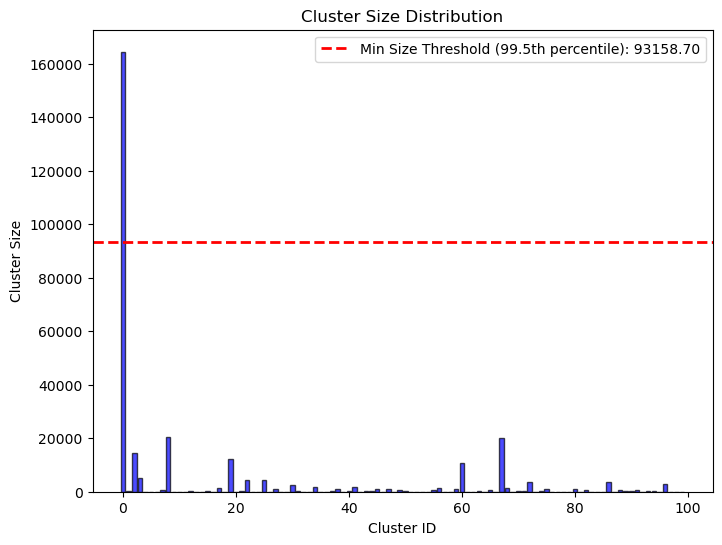

In [5]:
## Visualize the cluster size distribution

# Create a bar chart of cluster sizes
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes, color='blue', alpha=0.7, edgecolor='black')

# Plot a horizontal line at the percentile-based threshold
plt.axhline(y=min_size_threshold, color='red', linestyle='dashed', linewidth=2,
            label=f'Min Size Threshold ({hyperparams['per_min_size']}th percentile): {min_size_threshold:.2f}')

plt.xlabel('Cluster ID')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Distribution')
plt.legend()
plt.show()

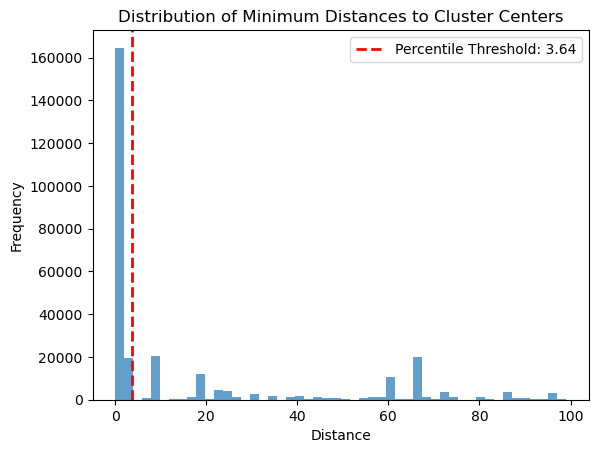

In [6]:
## Visualisze the distance distribution

plt.figure()
plt.hist(assigned_clusters, bins=50, alpha=0.7)
plt.axvline(percentile_threshold, color='red', linestyle='dashed', linewidth=2,
            label=f'Percentile Threshold: {percentile_threshold:.2f}')
plt.title('Distribution of Minimum Distances to Cluster Centers')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

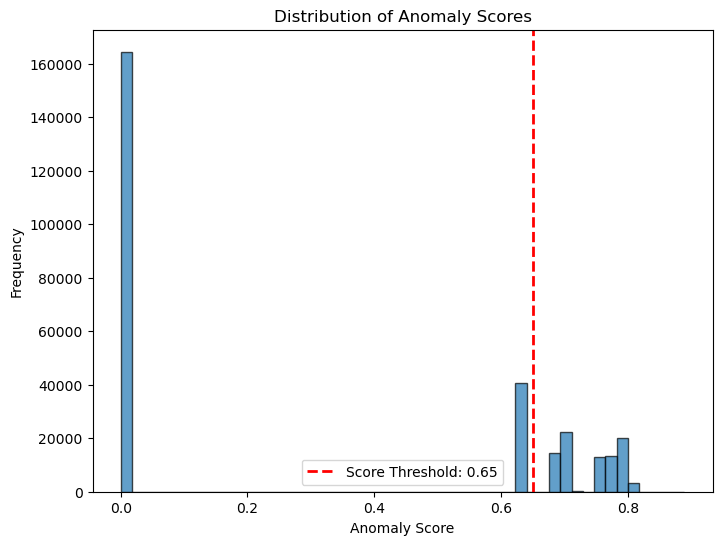

In [7]:
## Visualize the distribution of anomaly scores

plt.figure(figsize=(8, 6))
plt.hist(anomaly_score, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')

plt.axvline(x=score_threshold, color='red', linestyle='dashed', linewidth=2,
            label=f'Score Threshold: {score_threshold:.2f}')
plt.legend()
plt.show()

In [8]:
## Get evaluation metrics specific for clustering.
# - Davies-Bouldin: Measures models performance by comparing the average similarity between the pairwise most similar clusters. Lower DBI is better.
# - Calinski-Harabasz Index: Compares the ratio of the between-cluster dispersion with the within-cluster dispersion. Higher CI is better.
# - Silhouette Score: Measues how well each data point is clustered by assessing its similarity to its own cluster compated to other clusters (the average).
#    Close to +1 indicates that the datapoint is well defined to its cluster. Negative means that the data point has been assigned to the wrong cluster.
#    And close to 0 suggets that the data point is close to the descision boundary of two clusters. It is not well defined.

from sklearn.utils import check_random_state
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sample_size = 5000
random_state = check_random_state(42)
sil_score = silhouette_score(x_test, x_test['cluster'], sample_size=sample_size, random_state=random_state)
dbi_score = davies_bouldin_score(x_test, x_test['cluster'])
ch_score = calinski_harabasz_score(x_test, x_test['cluster'])

print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", dbi_score)
print("Calinski-Harabasz Index:", ch_score)

Silhouette Score: 0.8527358213049442
Davies-Bouldin Index: 0.4472557482940712
Calinski-Harabasz Index: 5572848.8460471155


In [9]:
## Evalutate Anomaly Detection

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score,  roc_auc_score, accuracy_score

# Convert multi-class labels to binary (0: Normal, 1: Attack)
y_test_binary = np.where(y_test == 0, 0, 1)

# Ensure predictions are aligned
predicted_anomalies = x_test['anomaly'].reset_index(drop=True)

print("Classification Report:")
print(classification_report(y_test_binary, predicted_anomalies, target_names=["Normal", "Attack"], zero_division=0))

# Calculate evaluation metrics
precision = precision_score(y_test_binary, predicted_anomalies, zero_division=0)
recall = recall_score(y_test_binary, predicted_anomalies, zero_division=0)
f1 = f1_score(y_test_binary, predicted_anomalies, zero_division=0)
accuracy = accuracy_score(y_test_binary, predicted_anomalies)

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

try:
    roc_auc = roc_auc_score(y_test_binary, predicted_anomalies)
    print(f"ROC AUC:   {roc_auc:.4f}")
except ValueError:
    print("Couldn't compute ROC AUC");

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.95    223298
      Attack       0.78      0.99      0.87     68963

    accuracy                           0.93    292261
   macro avg       0.89      0.95      0.91    292261
weighted avg       0.95      0.93      0.94    292261


Evaluation Metrics:
Accuracy:  0.9331
Precision: 0.7829
Recall:    0.9912
F1 Score:  0.8748
ROC AUC:   0.9532


Number of samples with label 0 (normal): 223298
Number of samples with label 1 (attack): 68963


<Figure size 800x600 with 0 Axes>

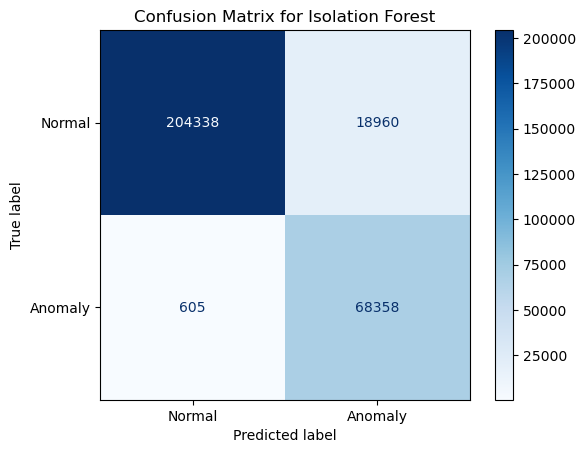

In [10]:
## Make a Confusion Matrix Plot

from sklearn.metrics import ConfusionMatrixDisplay

print("Number of samples with label 0 (normal):", np.sum(y_test_binary == 0))
print("Number of samples with label 1 (attack):", np.sum(y_test_binary == 1))

cm = confusion_matrix(y_test_binary, predicted_anomalies)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Anomaly'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Isolation Forest')
plt.grid(False)
plt.show()

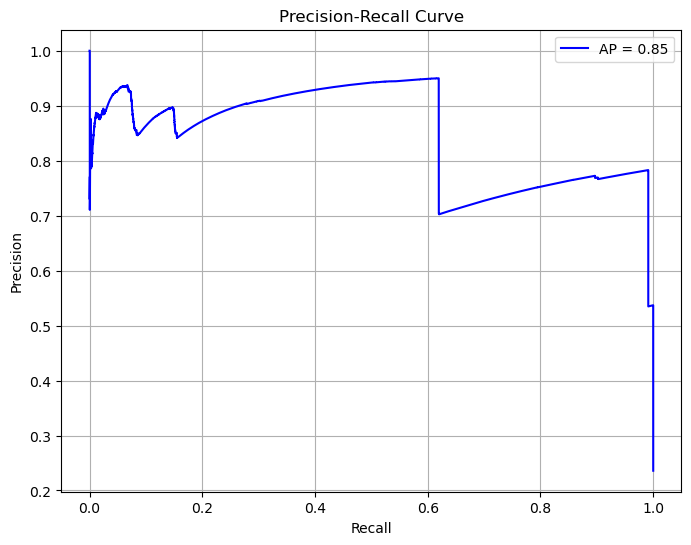

In [11]:
## Precision-Recall Curve

from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision, recall and thresholds using the anomaly scores and true labels
precision, recall, thresholds = precision_recall_curve(y_test_binary, anomaly_score)

# Calculate the average precision (AP) score
ap_score = average_precision_score(y_test_binary, anomaly_score)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()